# Introduction

For the project, the group decided to implement a convolutional neural network in order to use it for recognizing handwritten digits. Before this could be achieved, the group had to invest time to get a better grasp of understanding how CNN works. 
In order to achieve that, a simpler neural network had to be built, which would serve as a foundation for creating the full CNN model.

The document will introduce the groups approach for building the CNN model. Firstly, the document will introduce how was the simple neural network built and showcase the initial results for recognizing digits.
Secondly, the document will explain how was the CNN model built and explain whether it is better than a simple neural network by comparing the results.

The document will also present how the group experimented with different attributes such as learning rate, momentum and random seed numbers and explain what effect do they have for the model.
Lastly, the document will also discuss whether using a neural network for handwritten digit recognition had any ethical impact in the real world.

# Neural network

The implementation of our neural network was inspired by a third-party source [1] which introduces how to implement a neural network to people who are new to the topic. Therefore, certain variables such as the batch sizes, the learning rate as well as the momentum were kept the same. This was due to the fact that even when we slightly changed the numbers, it did not have an impact on the final results.

The following section will introduce our implementation of the neural network. The section will also cover the results such as how well did the network learn about the dataset and was it able to accurately predict the digits.

First, we import all the libraries which are used for importing the dataset and creating the network.

In [12]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from IPython.display import HTML, Image, display

Then, we create static variables that will be used later. These variables consists of values such as the rate at which the network learns from the data.

In [13]:
# Number of times to rerun the training dataset
epochs = 2

# How many images to feed through the network each time
batch_size_train = 64
batch_size_test = 1000

# Step size for gradiant decent
learning_rate = 0.01

# Gives the network a chance to jump out of a local minima
momentum = 0.5

# Use a constant seed for randomness so that reruns becomes predictable
random_seed = 1
torch.manual_seed(random_seed)

torch.backends.cudnn.enabled = False

The following code blocks provides the data set with handwritten digits. It converts the images into Pytorch tensors and normalizes the pixels into the range 0 to 1.

In [14]:
training_set = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                             torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_train, shuffle=True)

test_set = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_test, shuffle=True)

The following line of code simply outputs the structure of the data. The output here shows that each batch in the training data contains 64 images and that each image has 28x28 pixels dimension.

In [15]:
examples = enumerate(training_set)
_, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 28, 28])

The code block below plots different numbers from the dataset to show numbers and different ways people wrote them down. Each image has a ground truth which simply means what number does the image represent. This is a way to show that everyone has a different handwriting and the network should be capable of recognizing most of the numbers.

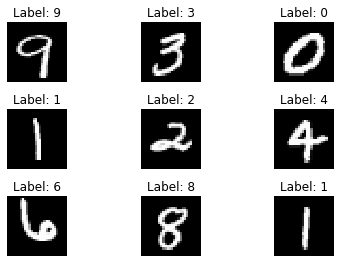

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(example_targets[i]))
    plt.axis('off')

The following function simply creates and returns a model that contains 3 layers: a 28x28 input layer, a hidden layer of 50 nodes and an output layer of size 10. The LogSoftmax is for normalizing the output vector to a range between 0 and 1.

In [17]:
def create_model():
    return nn.Sequential(
        nn.Linear(28 * 28, 50),
        nn.ReLU(),
        nn.Linear(50, 10),
        nn.LogSoftmax(1)
    )

The following code block trains the network with the handwritten digit data (training_set). It iterates over an n amount of epochs. It also iterates over each batch from the training_set. At each iteration, it adjusts the weights as well as calculating the loss. This allows us to see how accurate is the prediction of each batch. The accuracy is stored in an array which helps to plot the training process of the network.

In [18]:
def train_model(model):
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    total = 0
    nr_correct = 0

    accuracy = []
    for n in range(0, epochs):
        for (batch_index, (images, labels)) in enumerate(training_set):
            images = images.view(images.shape[0], -1)
            result = model(images)

            optimizer.zero_grad()

            loss = criterion(result, labels)
            loss.backward()

            optimizer.step()

            _, predictions = torch.max(result, 1)
            total = images.size(0)
            nr_correct = torch.sum(predictions == labels).item()

            accuracy.append(nr_correct / total)
            
    return accuracy

The purpose of this function create a test model which can be used to compare to the training model. It is used to check if the model generalized to the other data.

In [19]:
def test_model(model, test_set):
    total = 0
    nr_correct = 0
    
    for images, labels in test_set:
        images = images.view(images.shape[0], -1)
        result = model(images)
        
        _, predictions = torch.max(result, 1)
        total += images.size(0)
        nr_correct += torch.sum(predictions == labels).item()
                
    return nr_correct / total

The function within the codeblock below uses the information obtained from the training to plot the rate at which the network learns about the data. The plot contains the amount of training batches and the accuracy of the model during the training.

In [20]:
def plot_learning_rate(batch_accuracies):
    fig, ax = plt.subplots()
    ax.plot(
        range(0, len(batch_accuracies)), 
        batch_accuracies
    )

    ax.set_ylim((0, 1))
    ax.set(
        xlabel='training batches', 
        ylabel='accuracy',
        title='Model accuracy during training'
    )

    plt.show()

The following lines of code simply calls out the previously mentioned functions in order to create the model, train it and plot it the information about its accuracy during training.

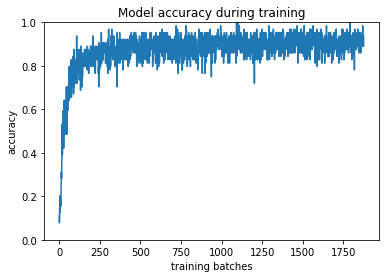

In [21]:
model = create_model()
accuracy = train_model(model)
plot_learning_rate(accuracy)


The function below plots a the accuracy of the networks prediction of a single handwritten number from the test_set.
The generated graph displays all possible 10 numbers and shows which are the closest numbers that match the handwritten number.

In [22]:
def plot_image_classification(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray', interpolation='none')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

It's time to see how well our network generalize to the test set.

In [23]:
test_model(model, test_set)

0.9134

The following code block fetches images and labels of the handwritten numbers. It fetches a single number from test_set and prints it out as an image to allow the user to know which handwritten number the network tried to predict.
Together with the previously mentioned function, this allows to show the number that the network tries to guess together with the graph that displays the network's accuracy.

Predicted Digit:  1
Original Label:  1


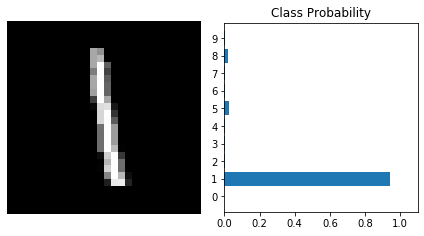

In [24]:
images, labels = next(iter(test_set))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit: ", probab.index(max(probab)))
print("Original Label: ", labels[0].item())
plot_image_classification(img.view(1, 28, 28), ps)

In [25]:
correct_count, all_count = 0, 0
predicted_labels = []
actual_labels = []
for images,labels in test_set:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)

        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        
        predicted_labels.append(pred_label)
        actual_labels.append(true_label)
        
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print(correct_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000
9134

Model Accuracy = 0.9134


# Confusion matrix

In order to evaluate the accuracy of our neural network, we decided to construct a confusion matrix. The purpose of it is to help the group understand which certain numbers from the digit dataset provided the most issues. This way, it helped us understand if certain digits made the network doubt on determining the exact number it is currently looking at. With these results, it would be possible to adjust the network to reduce the odds of these problems occuring.

The way the matrix works is that it uses the data from the testing function (predicted_labels, actual_labels). Because the testing function goes over each number and informs whether it recognized the number or not, this allows the matrix to sort this information and illustrate it in a more understandable way.

In [26]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
           
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # print(cm)

    fig, ax = plt.subplots(figsize = (10, 10))
    im = ax.imshow(cm,cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    x_classes = classes 
    classes.reverse()
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),       
           xticklabels=x_classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right")

    # Loop over data dimensions and create text annotations.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color="white" if cm[i, j] > 500 else "black"
            ax.text(j, i, format(cm[i, j]), ha="center", va="center", color=color)
    
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5)
    plt.show()


The following code block labels the numbers we want to illustrate, ranging from 0 to 9. It also calls out the function defined above with the data collected from the training function.

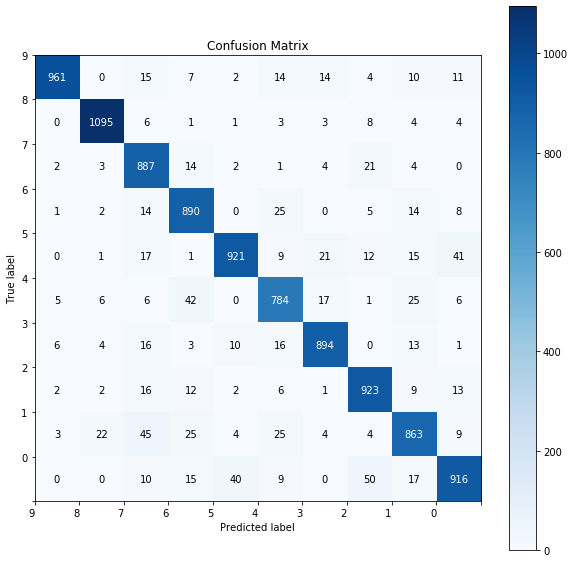

In [27]:
label_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,]

plot_confusion_matrix(predicted_labels, actual_labels, label_list)

# Creating the CNN and searching for hyper params

*SOME GENERAL BLOCK EXPLAINING GRID SEARCH AND OUR PLAN*

@TODO something about why we don't test different batch sizes here?@
@TODO why we will only try one epoch for all models, going through 1000+ combinations takes long time@
@TODO something about missing models with slow learning rate?@
@TODO something about why we have chosen grid search over just random search?@

## CNN Model

In [8]:
class Model(nn.Module):
    def __init__(self, hyper_params):
        super(Model, self).__init__()
        self.hyper_params = hyper_params
        
        layers = []
        for n in self.hyper_params['conv_layers']:
            conv_layer = nn.Conv2d(
                n['in_channels'], 
                n['out_channels'], 
                n['kernel_size']
            )
            layers.append(conv_layer)
            layers.append(self.get_activation_function())
            layers.append(nn.MaxPool2d(2))
        self.conv = nn.Sequential(*layers)
        
        layers = []
        for i in range(len(self.hyper_params['regular_layers']) - 1):
            nr_in = self.hyper_params['regular_layers'][i];
            nr_out = self.hyper_params['regular_layers'][i + 1];
            layers.append(nn.Linear(nr_in, nr_out))
            layers.append(self.get_activation_function())
        
        # The output layer should not have an activation function
        layers.pop()
        
        self.net = nn.Sequential(*layers)
          
        learning_rate = self.hyper_params['learning_rate']
        momentum = self.hyper_params['momentum']
        optimizer = self.hyper_params['optimizer']
        if optimizer == 'SGD':
            self.optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum)
        elif optimizer == 'Adam':
            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        else:
            raise Exception('Invalid optimizer')
            
        criterion = self.hyper_params['criterion']
        if criterion == 'CrossEntropy':
            self.criterion = nn.CrossEntropyLoss()
        else:
            raise Exception('Invalid criterion')
            
        if run_on_gpu:
            self.to(device)
        
        
    def get_activation_function(self):
        fun = self.hyper_params['activation_function']
        if fun == 'ReLU':
            return nn.ReLU()
        if fun == 'Sigmoid':
            return torch.nn.Sigmoid()
        if fun == 'Swish':
            return Swish()
        
        
    def forward(self, tensor):
        tensor = self.conv(tensor)
        tensor = tensor.reshape(tensor.size(0), -1)
        return self.net(tensor)
    
    
    def fit(self, tensor, labels):
        if run_on_gpu:
            tensor = tensor.to(device)
            labels = labels.to(device)
        result = self(tensor)
        
        self.optimizer.zero_grad()
        loss = self.criterion(result, labels)
        loss.backward()
        self.optimizer.step()
        
        _, predictions = torch.max(result, 1)
        total = tensor.size(0)
        nr_correct = torch.sum(predictions == labels).item()
        
        return (nr_correct / total, loss.item())

This class constructs a model from a dictionary of hyper parameters which allows us to have a variable amount of convolutional layers, hidden layers and different activation functions etc. We've chosen to have a dictionary instead of multiple params to the constructor for an easy way to save, load and print the different model parameters.

Based on @TODO BASE IT ON SOMETHING@ and in order to reduce the amount of different combinations that can be made, we have chosen to only have the convolutional layers in the start of the network and to an activation function and a pooling layer for each convolutional layer.

The forward function describes what steps to make when running the network. We are first running the input tensor through convolutional layers then converting the output to a vector which we feed though the rest of the network. The function gets called when running the network because we are extending nn.Module

The fit function runs the network and does backpropagation. It returns the accuracy and loss for the input tensor.

## Grid search

In [9]:
def hyper_parameter_permutations():
    layer_sizes = [32, 64, 128]
    hidden_layers = [list(n) for n in itertools.permutations(layer_sizes, 1)]\
                  + [[a, b] for (a, b) in itertools.permutations(layer_sizes, 2) if a >= b]
    
    channel_sizes = [4, 8, 16]
    conv_layers = [list(n) for n in itertools.permutations(channel_sizes, 1)]\
                + [[a, b] for (a, b) in itertools.permutations(channel_sizes, 2) if a <= b]
    
    kernel_sizes = [5]
    activation_functions = ['ReLU', 'Sigmoid', 'Swish']
    criterions = ['CrossEntropy']
    
    #Adding momentum directly to the optimizer since it's only used for SGD
    optimizers = [('SGD', 0.1), ('SGD', 0.5), ('SGD', 1.0), 'Adam']
    learning_rates = [0.1, 0.01, 0.001]

    return itertools.product(
        hidden_layers,
        conv_layers,
        kernel_sizes,
        activation_functions,
        criterions,
        optimizers,
        learning_rates
    )

In [10]:
class Swish(nn.Module):
    def forward(self, input_tensor):
        return input_tensor * torch.sigmoid(input_tensor)

The function hyper_parameter_permutations creates a list of all different permutations that we want to test in our search.
As mentioned earlier we based our convolutional network on @TODO BASE IT ON SOMETHING@ and therefore we are using that networks hyper parameters as our starting point. @TODO something about the choice of ranges?@ @TODO something about the limitations that we had to make?@

Hidden layers and convolution layers:
todo

Kernel size:
In order to reduce the amount of combinations we are only testing one kernel size.

We are testing three different activation functions: Sigmoid, ReLU and Swish.
Sigmoid bad
ReLU everyone uses
Swish new from google, supposedly good

Criterions:
Searching through the Internet for good loss functions for classification problems, we only found NLLLoss (The negative log likelihood loss) and Cross Entropy loss that worked with our existing model. Since Cross Entropy Loss is the same as NLLLoss and LogSoftMax @@EXPLAINATION@@ combined we are only using that one.

Optimizers:
todo

Learning rates: 
todo

In [11]:
def permutation_to_dictionary(hidden_layers, channel_sizes, kernel_size, act_fun, criterion, optimizer, learning_rate):
    conv_layers = []
    in_channels = 1
    side_length = 28
    for channel_size in channel_sizes:
        out_channels = channel_size
        conv_layers.append(
            {
                'in_channels': in_channels,
                'out_channels': out_channels,
                'kernel_size': kernel_size
            }
        )
        in_channels = out_channels
    
        side_length -= kernel_size - 1
        side_length //= 2
        
    if type(optimizer) is tuple:
        momentum = optimizer[1]
        optimizer = optimizer[0]
    else:
        momentum = 0
    
    regular_layers = [side_length * side_length * out_channels] + hidden_layers + [10]
    return {
        'conv_layers': conv_layers,
        'regular_layers': regular_layers,
        'activation_function': act_fun,
        'optimizer': optimizer,
        'criterion': criterion,
        'learning_rate': learning_rate,
        'momentum': momentum
    }

This function converts the hyper parameter permutations to the dictionary format that we use to construct the models.

In [12]:
def grid_search():
    gc.collect()
    before = time.time()

    models = []
    
    permutations = list(hyper_parameter_permutations())
    
    print("Searching through {} permutations".format(len(permutations)))

    i = 0
    for n in permutations:
        grid_search_helper(n, models)
        break
        i += 1
        
        if i % 100 == 0:
            print("{} complete, time elapsed: {:.2f} minutes".format(i, (time.time() - before) / 60))
            
        if i % 500 == 0:
            gc.collect()

    models.sort(key=lambda n: n[0], reverse=True)

    after = time.time()
    print("Done, took {:.2f} minutes".format((after - before) / 60))
    
    return models

# Wrapper function that allows the garbage collector to run
def grid_search_helper(permutation, models):
    hyper_params = permutation_to_dictionary(*permutation)
    model = Model(hyper_params)
    train_model(model)
    accuracy = test_model(model, test_set)
    models.append((accuracy, model.hyper_params))


Here is the actual search, where we are searching for the model with the highest accuracy by going though all permutations, constructing a model for each, training it and comparing the model to the test set. Then storing the models hyper parameters along with the accuracy in a sorted list from best accuracy to worst. In our first run we ran out of memory so we had to wrap the logic for each model in a separate function so that we could run the garbage collector.

In [13]:
def write_json(params, filename):
    params_json = json.dumps(params)
    f = open(filename, "w")
    f.write(params_json)
    f.close()
    
def read_json(filename):
    f = open(filename, "r")
    params = json.loads(f.read())
    f.close()
    return params

Because we don't want to perform our lengthy grid search multiple times, we have a simple read/write to a json file.

In [1]:
epochs = 1
models = grid_search()
write_json(models, "one_epoch_models.json")

*BLOCK ABOUT RUNNING IT + DISPLAY GRAPH + DRAW CONCLUSION ABOUT HYPER PARAMS*

## Training networks for multiple epochs

# External CNN

After creating our own CNN model and evaluating both the training accuracy and testing accuracy, the next step was to find an external CNN model. This would be done to further evaluate our custom model to determine if it is performing the same or even better than previously existing CNN models.

A CNN model was discovered on [2] which both explains how each parts of the network work as well as provide the full source code for other people to test it.

This section will quickly go over the parts of the external CNN model and explain whether this model is better than our own custome one.

The following code block imports the same dataset of handwritten digits as the previous neural network. However, it splits the data into 3 different arrays, train_dataloader, val_dataloader and test_dataloader. The first array contains 60000 training images for the network to learn from. The second array is used to validate the network to determine whether the network is still providing the correct results, to determine if it is underfitting or overfitting. The third array is used to further test and validate the results once more for correctness.

In [28]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


This code block below simply prints out the first images in the the training dataset to show what data the network is working with. The color is different here than our dataset, because we adjusted our code to show the images in their true color instead of Python automatically showing them with different colors.

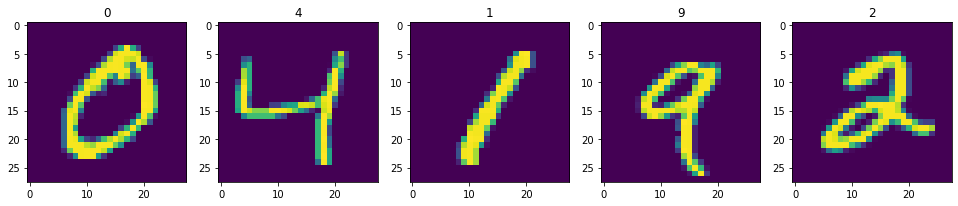

In [29]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
plt.show()

The following code block creates the CNN model. It consists of 2 convolutional layers, 1 max pooling layer, 2 hidden layers and an output layer. It also creates a feed-forward function that is used when sending data to the model.

In [30]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

The code below simply creates a new instance of the model, defines the criterion and the optimizer functions. It also initializes how many epochs will it iterate over as well as define variables that will be used for measuring the loss when training and validating the data.

In [43]:
model = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

no_epochs = 3
train_loss = list()
val_loss = list()
best_val_loss = 1

The code block below is the core part of the external CNN. Here a for loop iterates over an n amount of epochs. At each iteration, the network is trained with the training dataset. Afterwards, the CNN is validated with more data using a separate validation dataset. At each iteration, the loop prints out the training and validation loss and the measured accuracy.

In [45]:
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):

        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")


Epoch: 1/3, Train Loss: 0.28940977, Val Loss: 0.06155547, Val Accuracy: 0.98066667
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.06155547

Epoch: 2/3, Train Loss: 0.10061257, Val Loss: 0.03991461, Val Accuracy: 0.98611111
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03991461

Epoch: 3/3, Train Loss: 0.07529194, Val Loss: 0.03921202, Val Accuracy: 0.98744444
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.03921202


The following code block prints out the training and validation loss of the CNN.

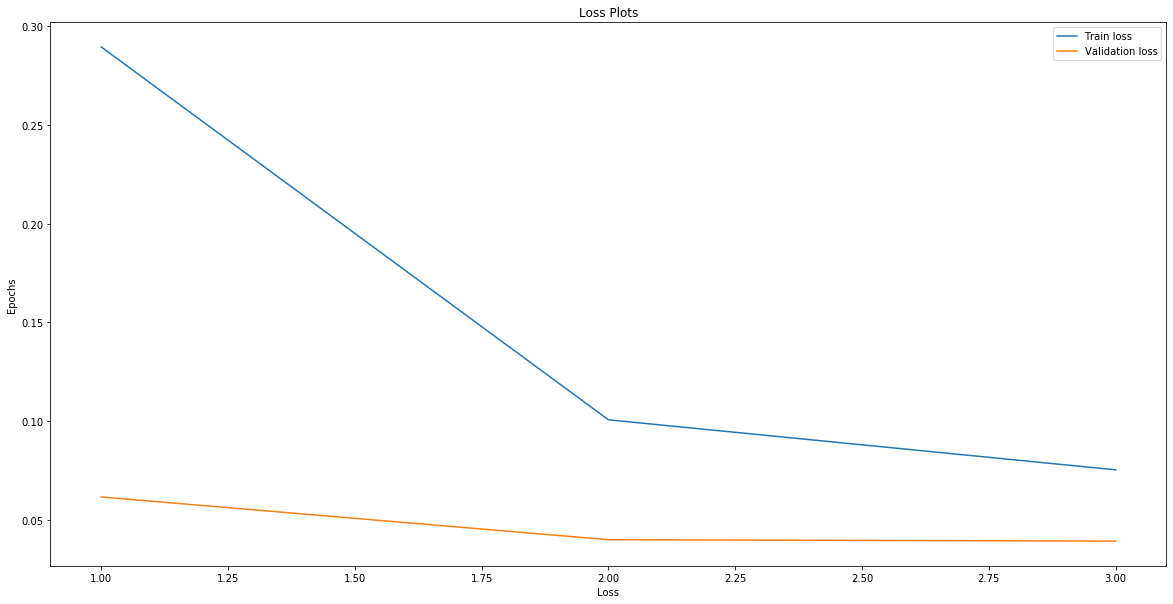

In [46]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

Finally, the following code block runs over a testing dataset, that consists of 1000 images. This is used to finalize the results and determine if the trained network provided accurate results.

In [57]:
# test model
model.load_state_dict(torch.load("model.dth"))
model.eval()

predicted_labels_CNN = []
actual_labels_CNN = []

results = list()
total = 0
for itr, (image, label) in enumerate(test_dataloader):

    pred = model(image)
    pred = torch.nn.functional.softmax(pred, dim=1)

    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            
            with torch.no_grad():
                logps = model(image)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = label.numpy()[i]

            predicted_labels.append(pred_label)
            actual_labels.append(true_label)
            
            results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = total / len(mnist_testset)
print('Test accuracy {:.8f}'.format(test_accuracy))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 32 1 3 3, but got 2-dimensional input of size [1, 784] instead

C:\Users\Aurelijus\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  
C:\Users\Aurelijus\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  


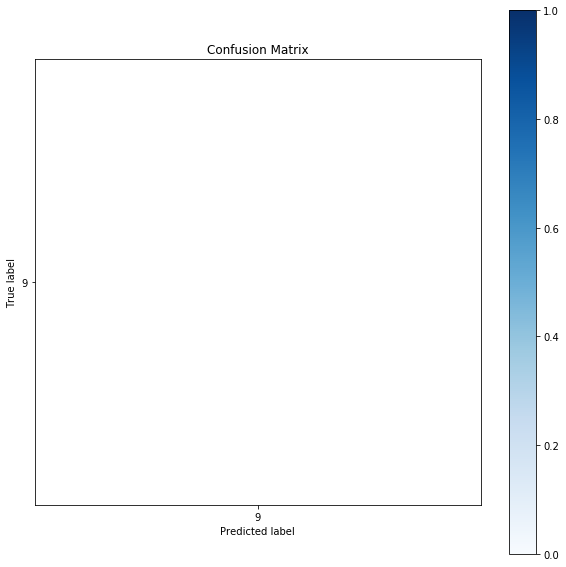

In [56]:
label_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,]
plot_confusion_matrix(predicted_labels_CNN, actual_labels_CNN, label_list)

# Comparing results

# The Social, Economic and Societal Aspects of the work

The task of handwritten digit recognition can be used for online handwriting recognition on computer tablets, recognizing zip codes on mail for postal mail sorting, processing bank check amounts, numeric entries in forms filled up by hand (for example ‐ tax forms). People can write same digits in different ways such as digit 1 and 7 can be written as:

In [ ]:
display(HTML("<table><tr><td><img src='img/digit1and7part1.jpg'></td><td><img src='img/digit1and7part2.jpg'></td></tr></table>"))

The first image shows how people from English speaking countries write the digits whereas the second image shows how people from continental Europe write those digits [3]. 

A lot of times the prescription written by medical professionals are unreadable and only people who are part of the medical industry like pharmacists, chemists etc. Only they can understand the handwritten prescriptions of the doctors. This could be another use of the handwritten digit recognition. 

The handwritten digit recognition system could be expanded to recognize digits written in different writing systems for example in roman the digits are:

In [ ]:
display(HTML("<table><tr><td><img src='img/numbers1.jpg'></td></tr></table>"))

Whereas in Chinese(simple) the digits are written as:

In [ ]:
display(HTML("<table><tr><td><img src='img/numbers2.jpg'></td></tr></table>"))

The information about the different writing order can be found from [4].

# Challenges

During the project implementation, there were several challenges that the group had to face. Of the main challenges occured during the initial phase, where the group had to implement the simple neural network. Due to the fact that every group member had different experiences, it took some time to ensure that every member understand the concept behind neural networks. Only when that step was achieved, the group was able to create a simple neural network.

# References

[1] https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

[2] https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9

[3] https://english.stackexchange.com/questions/62586/why-is-1-hand-written-without-a-serif-and-7-without-a-dash

[4] https://www.omniglot.com/language/numerals.htm